In [1]:
import torch
import numpy as np
import pandas as pd
import transformers
import os
from torch.utils.checkpoint import checkpoint
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import nn
from tqdm import tqdm
from datasets import load_dataset
from torchvision import transforms, models
from transformers import BertTokenizer
import matplotlib.pyplot as plt

## Dataset preparation

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
dataset_dir = '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/'

In [4]:
ans_space_path = f'{dataset_dir}/answer_space.txt'

with open(ans_space_path, 'r') as f:
    data = f.read()
    classes = data.split('\n')
    n_classes = len(classes)

    classes_to_idx = {
        cls_name: idx for idx, cls_name in enumerate(classes)
    }

    idx_to_classes = {
        idx: cls_name for idx, cls_name in enumerate(classes)
    }

In [ ]:
class VQADataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None, preprocessed_file=None):
        if preprocessed_file and os.path.exists(preprocessed_file):
            self.data = torch.load(preprocessed_file)
        else:
            self.data = self.preprocess_data(csv_file, image_folder)
            if preprocessed_file:
                torch.save(self.data, preprocessed_file)

        self.image_folder = image_folder
        self.transform = transform

    def get_vocab_size(self):
        return self.tokenizer.vocab_size
    
    def preprocess_data(self, csv_file, image_folder):
        df = pd.read_csv(csv_file)
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer = tokenizer

        preprocessed_data = []
        for _, row in tqdm(df.iterrows(), total=len(df)):
            image_id = row['image_id']
            question = row['question']
            answer = row['answer']

            encoding = tokenizer(
                question,
                max_length=512,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            input_ids = encoding['input_ids'].squeeze(0)
            attention_mask = encoding['attention_mask'].squeeze(0)

            answer_id = classes_to_idx[answer.split(',')[0]]

            preprocessed_data.append({
                'image_id': image_id,
                'question': question,
                'answer': answer,
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'answer_id': answer_id
            })

        return preprocessed_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point = self.data[idx]
        image_id = data_point['image_id']
        input_ids = data_point['input_ids']
        attention_mask = data_point['attention_mask']
        answer_id = data_point['answer_id']
        question = data_point['question']
        answer = data_point['answer']

        image_path = os.path.join(self.image_folder, f"{image_id}.png")
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, question, answer, input_ids, attention_mask, answer_id

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VQADataset(dataset_dir + 'data_train.csv',
                           dataset_dir + 'images',
                           transform)
val_dataset = VQADataset(dataset_dir + 'data_eval.csv',
                         dataset_dir + 'images',
                         transform)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 2494/2494 [00:01<00:00, 1482.23it/s]


In [7]:
def imshow(image_tensor):
    image_tensor = image_tensor.clone().detach()
    image_tensor = image_tensor.permute(1, 2, 0)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_tensor = image_tensor.numpy() * std + mean

    image_tensor = np.clip(image_tensor, 0, 1)
    plt.imshow(image_tensor)
    plt.axis('off')
    plt.show()

In [8]:
len(train_dataset), len(val_dataset)

(9974, 2494)

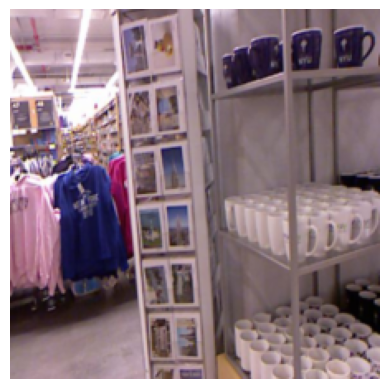

what is the object on the shelves
cup


In [9]:
image, question, answer, input_ids, attention_mask,_ = train_dataset[0]

imshow(image)
print(question, answer, sep='\n')

In [10]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True)

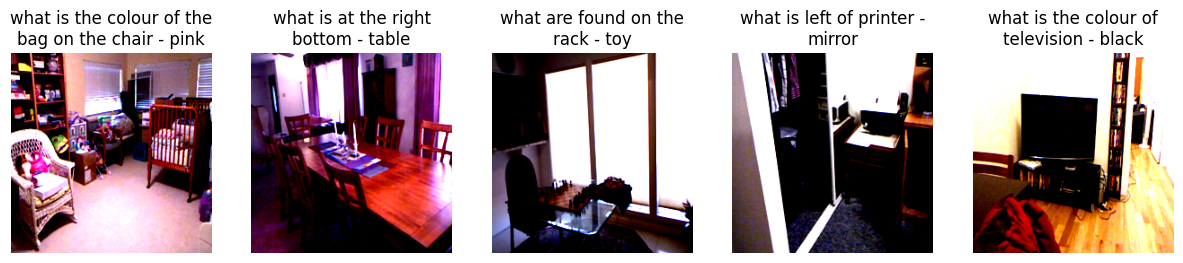

In [11]:
import textwrap

for images, questions, answers, input_ids, attention_mask,_ in val_loader:
    images = images[:5]
    questions = questions[:5]
    answers = answers[:5]
    
    images = images * 0.5 + 0.5
    images_np = images.numpy().transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for idx in range(5):
        axes[idx].imshow(images_np[idx])
        wrapped_text = "\n".join(textwrap.wrap(questions[idx] + " - " + answers[idx], width=25))
        axes[idx].set_title(wrapped_text)
        axes[idx].axis('off')
    plt.show()
    
    break

## NLP model

### Bert based

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel, BertTokenizer

In [13]:
class BERTTextEncoder(nn.Module):
    def __init__(self,finetune=True):
        super(BERTTextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = finetune
    
    def forward(self, input_ids, attention_mask):
        outputs = checkpoint(self.bert, input_ids, attention_mask,use_reentrant=False)
        return outputs.last_hidden_state[:, 0, :]

In [14]:
image, question, answer, input_ids, attention_mask,_ = train_dataset[0]
bert_encoder = BERTTextEncoder()

with torch.no_grad():
    embedding = bert_encoder(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))

print("Embedding shape:", embedding.shape)
print("Embedding:\n", embedding)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding shape: torch.Size([1, 768])
Embedding:
 tensor([[-1.9107e-01,  2.3815e-01,  1.9176e-03,  1.7936e-02, -1.1061e-01,
          5.3030e-02,  3.2129e-01,  4.1568e-01, -3.5410e-01, -8.3554e-02,
          5.9894e-02, -1.1319e-01,  1.2816e-01,  4.5366e-01,  6.0527e-02,
          2.6019e-02, -1.3498e-01,  6.1124e-01,  2.9227e-01,  7.9067e-02,
         -1.2588e-02, -1.1963e-01, -2.8246e-01, -4.1931e-01,  5.7790e-02,
          6.9246e-02, -1.0182e-01, -3.7026e-01, -2.1240e-01, -6.7674e-02,
          6.4129e-02, -6.2312e-02, -6.1010e-02, -1.2331e-01, -9.9664e-02,
         -1.8556e-01,  3.0702e-01, -1.6428e-01, -1.2250e-01,  1.3320e-01,
         -1.9803e-01, -2.1252e-01,  3.6090e-02, -2.7810e-02, -1.1159e-01,
         -3.4002e-01, -2.3789e+00, -4.3168e-01, -2.5859e-01, -2.0048e-02,
          1.4877e-01,  7.6130e-02,  4.0898e-01,  2.8403e-01, -1.1412e-01,
          1.2776e-01, -1.0444e-01,  4.4734e-01,  2.2408e-02, -2.9629e-01,
          2.3972e-01, -3.0166e-01,  5.6415e-02, -9.6971e-02,  

### LSTM based

In [15]:
class LSTMTextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim=2048, num_layers=2):
        super(LSTMTextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, questions,mask=None):
        embeds = self.embedding(questions)
        _, (hidden, _) = self.lstm(embeds)
        hidden_last_layer = hidden[-1]
        output = self.fc(hidden_last_layer)
        return output

In [16]:
vocab_size = train_dataset.get_vocab_size()
embed_dim = 768
hidden_dim = 1024
output_dim = 2048

In [17]:
lstm_encoder = LSTMTextEncoder(vocab_size, embed_dim, hidden_dim)

with torch.no_grad():
    lstm_embedding = lstm_encoder(input_ids)

print("LSTM Embedding shape:", lstm_embedding.shape)
print("LSTM Embedding:\n", lstm_embedding)

LSTM Embedding shape: torch.Size([2048])
LSTM Embedding:
 tensor([ 0.1130,  0.0307, -0.0583,  ..., -0.0797, -0.0008,  0.0240])


In [18]:
input_ids.shape

torch.Size([512])

# CV model

### ResNet50 based

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import ViTModel

In [ ]:
class VisualEncoder_ResNet50(nn.Module):
    def __init__(self,finetune=True):
        super(VisualEncoder_ResNet50, self).__init__()
        
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()
        for param in self.resnet.parameters():
            param.requires_grad = finetune

        
    def forward(self, image):
        features = checkpoint(self.resnet, image, use_reentrant=False)
        return features

In [21]:
visual_encoder = VisualEncoder_ResNet50()

image, _, _, _, _,_ = train_dataset[0]

with torch.no_grad():
    features = visual_encoder(image.unsqueeze(0))

print("Extracted Features Shape:", features.shape)
print("Extracted Features:", features)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


Extracted Features Shape: torch.Size([1, 2048])
Extracted Features: tensor([[0.1500, 0.0145, 0.0552,  ..., 0.0221, 0.0754, 0.0407]])


### CNN based

In [ ]:
class VisualEncoder_CNN(nn.Module):
    def __init__(self, input_channels=3, feature_size=2048):
        super(VisualEncoder_CNN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(512, feature_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
    def forward(self, image):
        features = self.encoder(image)
        features = features.view(features.size(0),-1)
        return features

In [23]:
visual_encoder = VisualEncoder_CNN(feature_size=748)

image, _, _, _, _,_ = train_dataset[0]

with torch.no_grad():
    features = visual_encoder(image.unsqueeze(0))

print("Extracted Features Shape:", features.shape)
print("Extracted Features:\n", features)

Extracted Features Shape: torch.Size([1, 748])
Extracted Features:
 tensor([[4.3825e-02, 6.6080e-03, 1.8507e-04, 5.0174e-03, 1.4009e-03, 1.2098e-03,
         6.1457e-03, 4.6410e-02, 3.6409e-02, 1.2601e-04, 1.7037e-02, 8.2975e-03,
         6.9711e-03, 8.3095e-02, 1.4594e-02, 2.5046e-02, 3.2773e-02, 7.0865e-03,
         2.6439e-02, 7.6260e-03, 5.0827e-02, 8.7911e-04, 2.0038e-02, 7.8314e-03,
         4.8431e-03, 5.0306e-02, 3.9843e-02, 6.8802e-03, 4.9847e-02, 1.2496e-02,
         2.8088e-02, 4.1752e-02, 4.0016e-03, 4.2330e-02, 0.0000e+00, 0.0000e+00,
         7.8455e-04, 2.5005e-03, 5.3029e-03, 3.1753e-03, 1.2329e-02, 0.0000e+00,
         3.6623e-03, 4.7164e-03, 0.0000e+00, 4.8804e-02, 9.4335e-03, 1.9892e-04,
         6.6120e-02, 1.2815e-02, 8.2523e-03, 0.0000e+00, 6.0285e-02, 1.4916e-02,
         1.7460e-02, 3.8554e-02, 1.1879e-02, 5.5961e-03, 1.1259e-02, 3.3620e-02,
         5.3736e-05, 0.0000e+00, 2.7685e-02, 0.0000e+00, 1.3946e-02, 7.9313e-04,
         5.5026e-03, 2.2963e-02, 4.3715e-

In [24]:
image.shape

torch.Size([3, 224, 224])

### ViT based

In [ ]:
class VisualEncoder_ViT(nn.Module):
    def __init__(self, model_name='google/vit-base-patch16-224',finetune=False):
        super(VisualEncoder_ViT, self).__init__()
        
        self.vit = ViTModel.from_pretrained(model_name)

        for param in self.vit.parameters():
            param.requires_grad = finetune
        
    def forward(self, image):
        outputs = self.vit(image)
        return outputs.pooler_output

In [26]:
visual_encoder = VisualEncoder_ViT()

image, _, _, _, _,_ = train_dataset[0]

with torch.no_grad():
    features = visual_encoder(image.unsqueeze(0))

print("Extracted Features Shape:", features.shape)
print("Extracted Features:", features)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracted Features Shape: torch.Size([1, 768])
Extracted Features: tensor([[-1.3042e-02, -4.7623e-01,  5.6856e-01,  3.4872e-01,  2.6095e-01,
         -4.4203e-01,  1.5173e-01,  4.4974e-01, -2.7305e-01,  4.1116e-02,
          2.0531e-02,  9.4588e-02, -3.9667e-01, -4.5678e-01, -5.9809e-01,
          4.2886e-02,  2.8094e-01,  1.8327e-01,  2.2440e-01, -2.0831e-01,
          3.2610e-01, -8.2743e-01,  1.5382e-01, -7.3695e-02, -6.1601e-01,
         -3.3973e-01, -4.7969e-01,  6.7967e-01,  2.5567e-01, -8.8028e-02,
          9.1610e-02,  5.1929e-01, -1.2020e-01, -7.3588e-01,  2.7309e-01,
         -5.5308e-01,  3.5679e-01,  8.6916e-01,  2.7443e-01,  2.1346e-01,
         -5.7562e-02,  6.8134e-01,  2.2849e-01, -1.8577e-01, -6.5518e-01,
         -1.7378e-01, -5.0863e-03, -7.0237e-01,  3.1160e-01, -2.6400e-01,
          5.5724e-01,  8.6932e-02,  1.1727e-01,  5.8331e-01,  5.8849e-01,
         -7.5669e-02,  4.4356e-01,  7.3771e-01, -1.0151e-01, -5.2454e-01,
         -3.5639e-01, -2.6067e-01,  7.2954e-0

## VQA model

In [27]:
def get_output_shape(model, image_dim):
    return model(torch.rand(*(image_dim)).to(device)).data.shape

In [ ]:
class MultimodalAttention(nn.Module):
    def __init__(self, image_feature_dim, question_feature_dim, hidden_dim):
        super(MultimodalAttention, self).__init__()
        self.image_projection = nn.Linear(image_feature_dim, hidden_dim)
        self.question_projection = nn.Linear(question_feature_dim, hidden_dim)
        self.attention_scores = nn.Linear(hidden_dim, 1)
        
    def forward(self, image_features, question_features):
        projected_images = self.image_projection(image_features)
        projected_questions = self.question_projection(question_features)

        attention_weights = self.attention_scores(torch.tanh(projected_images + projected_questions.unsqueeze(1)))
        attention_weights = torch.softmax(attention_weights, dim=1)

        attended_image_features = attention_weights * projected_images.unsqueeze(1)
        attended_image_features = attended_image_features.sum(dim=1) 

        combined_features = attended_image_features + projected_questions
        return combined_features, attention_weights

class VQA_Attention(nn.Module):
    def __init__(self,target_size, image_encoder,text_encoder,device,hidden_size=1024,n_layers = 1,
                 dropout_prob=0.2, img_shape=(1,3, 224, 224),
                 text_shape=(1,512)):
        super(VQA_Attention, self).__init__()
        self.image_encoder=image_encoder
        enc_img_out = get_output_shape(image_encoder,img_shape)[1]
        self.text_encoder=text_encoder
        enc_text_out = text_encoder(torch.randint(0,1,text_shape).to(device),torch.randint(0,1,text_shape).to(device)).data.shape[1]
        
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = MultimodalAttention(enc_img_out,enc_text_out,hidden_size)

        self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.lin2 = nn.Linear( hidden_size, target_size)
        
    def forward(self, image, text, mask=None):
        img_features = self.image_encoder(image)
        text_features = self.text_encoder(text,mask)
        combined = self.attention(img_features , text_features)
        
        out,_ = combined
        for layer in self.hidden:
            out = self.dropout(out)
            out = layer(out)
            out = torch.nn.functional.relu(out)
        
        out = self.dropout(out)
        out = self.lin2(out)   
        
        return out

class VQA_model(nn.Module):
    def __init__(self,target_size, image_encoder,text_encoder,device,hidden_size=1024,n_layers = 1,
                 dropout_prob=0.2, img_shape=(1,3, 224, 224),
                 text_shape=(1,512)):
        super(VQA_model, self).__init__()
        self.image_encoder=image_encoder
        enc_img_out = get_output_shape(image_encoder,img_shape)[1]
        self.text_encoder=text_encoder
        enc_text_out = text_encoder(torch.randint(0,1,text_shape).to(device),torch.randint(0,1,text_shape).to(device)).data.shape[1]
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.lin1 = nn.Linear(enc_text_out+enc_img_out, hidden_size)
        self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.lin2 = nn.Linear( hidden_size, target_size)
        
    def forward(self, image, text, mask=None):
        img_features = self.image_encoder(image)
        text_features = self.text_encoder(text,mask)
        combined = torch.cat((img_features, text_features), dim=1)
        
        out = combined
        out = self.lin1(out)
        for layer in self.hidden:
            out = self.dropout(out)
            out = layer(out)
            out = torch.nn.functional.relu(out)
        
        out = self.dropout(out)
        out = self.lin2(out)   
        
        return out

In [ ]:
hidden_size = 1024
dropout_prob = 0.2
img_encoder = VisualEncoder_ResNet50().to(device)
vocab_size = train_dataset.get_vocab_size()

text_encoder = LSTMTextEncoder(
    vocab_size, 
    embed_dim = 768,
    hidden_dim = 1024,
    output_dim = 2048, 
    num_layers=1
).to(device)

model = VQA_model(n_classes,img_encoder,text_encoder,device = device,hidden_size = hidden_size,dropout_prob=dropout_prob).to(device)


for batch in train_loader:
    images, questions, answers, input_ids, attention_masks,targets = batch
    images, input_ids, masks, targets = images.to(device), input_ids.to(device),attention_masks.to(device), targets.to(device)
    print(answers)
    print(questions)
    print(input_ids.shape)
    with torch.no_grad():
        features = model(images, input_ids, masks)
    print("Ans Shape:", features.shape)
    print("Ans:", features)
    break
model.cpu()

['8', '9', '5', 'shelves', 'white', 'cabinet', 'monitor, mouse, paper', 'framed_certificate, picture', 'window', 'laptop, mouse, books, pen, paper', 'ornamental_item', 'black', 'toilet', 'bag', 'garbage_bin', 'box', 'cabinet', 'photo', 'window', '4', 'printer', 'flower_pot', '2', 'white', 'light', 'hair_dryer', 'table', 'sink', 'glass', 'tablecloth', 'sofa', 'table']
['how many chairs are there', 'how many chairs are there around the table', 'how many toilet papers are there', 'what is right of table', 'what is the colour of garbage bin', 'what is at the right side of the bed', 'what is on the table behind the chair', 'what is above the drawer', 'what is at the top right corner', 'what are the objects on top of the table', 'what is on the flush tank', 'what is the colour of the drawers', 'what is the object on the floor in front of the bathtub', 'what is near the printer', 'what is on the right side of the rack', 'what is found near the lamp', 'what is to the right of the bed', 'what i

VQA_model(
  (image_encoder): VisualEncoder_ResNet50(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


def validate(model, val_loader, criterion, optimizer, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        loop = tqdm(val_loader, desc=f"Epoch [Val]")
        for batch in loop:
            images, questions, answers, input_ids, attention_masks,targets = batch
            images, input_ids, masks, targets = images.to(device), input_ids.to(device),attention_masks.to(device), targets.to(device)

            outputs = model(images, input_ids, masks)
            loss = criterion(outputs, targets)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, dim=1)
            val_correct += (predicted == targets).sum().item()
            val_samples += targets.size(0)

    val_epoch_loss = val_loss / val_samples
    val_epoch_accuracy = val_correct / val_samples
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")
    return val_epoch_loss,val_epoch_accuracy

def train_vqa_model(model, train_loader, criterion, optimizer,scaler, device):
    model = model.to(device)
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    loop = tqdm(train_loader, desc=f"Epoch [Train]")
    for batch in loop:
        images, questions, answers, input_ids, attention_masks,targets = batch
        images, input_ids, masks, targets = images.to(device), input_ids.to(device),attention_masks.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images, input_ids, masks)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        loop.set_postfix(loss=loss.item(), accuracy=correct_predictions / total_samples)
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")
    return epoch_loss,epoch_accuracy

In [ ]:
import matplotlib.pyplot as plt


def plot_metric_history(history, model_name, metric_name):
    train_metric = history.get(metric_name)
    val_metric = history.get(f'val_{metric_name}')

    if train_metric is None or val_metric is None:
        raise ValueError(f"History must contain keys '{metric_name}' and 'val_{metric_name}'.")

    epochs = range(1, len(train_metric) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metric, label=f'Training {metric_name}', marker='o')
    plt.plot(epochs, val_metric, label=f'Validation {metric_name}', marker='s')
    plt.title(f"{model_name} - {metric_name} History", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(metric_name.capitalize(), fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## Model training

In [61]:
num_epochs = 20
lr = 1e-3
weight_decay = 5e-5
hidden_size = 1024
n_l = 0
dropout_prob = 0.5
vocab_size = train_dataset.get_vocab_size()

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True)

In [ ]:
import gc
import copy
from torch.cuda.amp import autocast, GradScaler

img_encoder.cpu()
text_encoder.cpu()
model.cpu()
gc.collect()
torch.cuda.empty_cache()

history = dict()

In [ ]:
from torch.cuda.amp import autocast, GradScaler


model_name = f'vqa_big_train'
history[model_name] = {'loss':[],'val_loss':[],'accuracy':[],'val_accuracy':[]}

img_encoder= VisualEncoder_ResNet50(finetune=False).to(device)
text_encoder= BERTTextEncoder(finetune=False).to(device)

model = VQA_Attention(n_classes,img_encoder,text_encoder,hidden_size,dropout_prob=dropout_prob,n_layers=n_l).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scaler = GradScaler()
scheduler_step_size = int(num_epochs * 0.25)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max')

/tmp/ipykernel_30/1698586834.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs} Model {model_name}')
    epoch_loss,epoch_accuracy = train_vqa_model(model, train_loader, criterion, optimizer,scaler, device)
    val_epoch_loss,val_epoch_accuracy = validate(model, val_loader, criterion, optimizer, device)

    history[model_name]['loss'].append(epoch_loss)
    history[model_name]['accuracy'].append(epoch_accuracy)
    history[model_name]['val_loss'].append(val_epoch_loss)
    history[model_name]['val_accuracy'].append(val_epoch_accuracy)

    scheduler.step(val_epoch_accuracy)
    
torch.save(model.state_dict(), f'{model_name}.pt')

Epoch 1/20 Model vqa_big_train


Epoch [Train]:   0%|          | 0/156 [00:00<?, ?it/s]/tmp/ipykernel_30/959535623.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.131, loss=4.21]


Train Loss: 4.4919, Train Accuracy: 0.1307


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 3.8356, Val Accuracy: 0.1864
Epoch 2/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.23, loss=3.24] 


Train Loss: 3.4979, Train Accuracy: 0.2302


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 3.5813, Val Accuracy: 0.2265
Epoch 3/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.291, loss=3.05]


Train Loss: 2.9860, Train Accuracy: 0.2911


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 3.5708, Val Accuracy: 0.2390
Epoch 4/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.327, loss=2.64]


Train Loss: 2.6734, Train Accuracy: 0.3265


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 3.7071, Val Accuracy: 0.2470
Epoch 5/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.345, loss=2.67]


Train Loss: 2.4724, Train Accuracy: 0.3449


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 3.8390, Val Accuracy: 0.2334
Epoch 6/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.376, loss=2.28]


Train Loss: 2.3094, Train Accuracy: 0.3764


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.0344, Val Accuracy: 0.2518
Epoch 7/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.39, loss=2.38] 


Train Loss: 2.2460, Train Accuracy: 0.3903


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.1555, Val Accuracy: 0.2233
Epoch 8/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.409, loss=1.9] 


Train Loss: 2.1462, Train Accuracy: 0.4087


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.1975, Val Accuracy: 0.2470
Epoch 9/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.425, loss=2.14]


Train Loss: 2.0873, Train Accuracy: 0.4254


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.2671, Val Accuracy: 0.2358
Epoch 10/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.434, loss=2.27]


Train Loss: 2.0644, Train Accuracy: 0.4339


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.4729, Val Accuracy: 0.2442
Epoch 11/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.451, loss=2.63]


Train Loss: 1.9986, Train Accuracy: 0.4507


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.4919, Val Accuracy: 0.2237
Epoch 12/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.464, loss=2.32]


Train Loss: 1.9271, Train Accuracy: 0.4638


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.6540, Val Accuracy: 0.2269
Epoch 13/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.467, loss=1.96]


Train Loss: 1.9491, Train Accuracy: 0.4669


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.6860, Val Accuracy: 0.2438
Epoch 14/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.463, loss=2.39]


Train Loss: 1.9540, Train Accuracy: 0.4628


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.13s/it]


Val Loss: 4.7084, Val Accuracy: 0.2285
Epoch 15/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.477, loss=2.37]


Train Loss: 1.9140, Train Accuracy: 0.4770


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.8811, Val Accuracy: 0.2358
Epoch 16/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.492, loss=1.76]


Train Loss: 1.8628, Train Accuracy: 0.4921


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.8537, Val Accuracy: 0.2462
Epoch 17/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.49, loss=2.39] 


Train Loss: 1.8543, Train Accuracy: 0.4901


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.9514, Val Accuracy: 0.2326
Epoch 18/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.591, loss=1.31] 


Train Loss: 1.3221, Train Accuracy: 0.5913


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.6480, Val Accuracy: 0.2530
Epoch 19/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.617, loss=1.32] 


Train Loss: 1.1896, Train Accuracy: 0.6165


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.5965, Val Accuracy: 0.2558
Epoch 20/20 Model vqa_big_train


Epoch [Train]: 100%|██████████| 156/156 [02:52<00:00,  1.11s/it, accuracy=0.63, loss=0.99]  


Train Loss: 1.1508, Train Accuracy: 0.6304


Epoch [Val]: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Val Loss: 4.6133, Val Accuracy: 0.2542


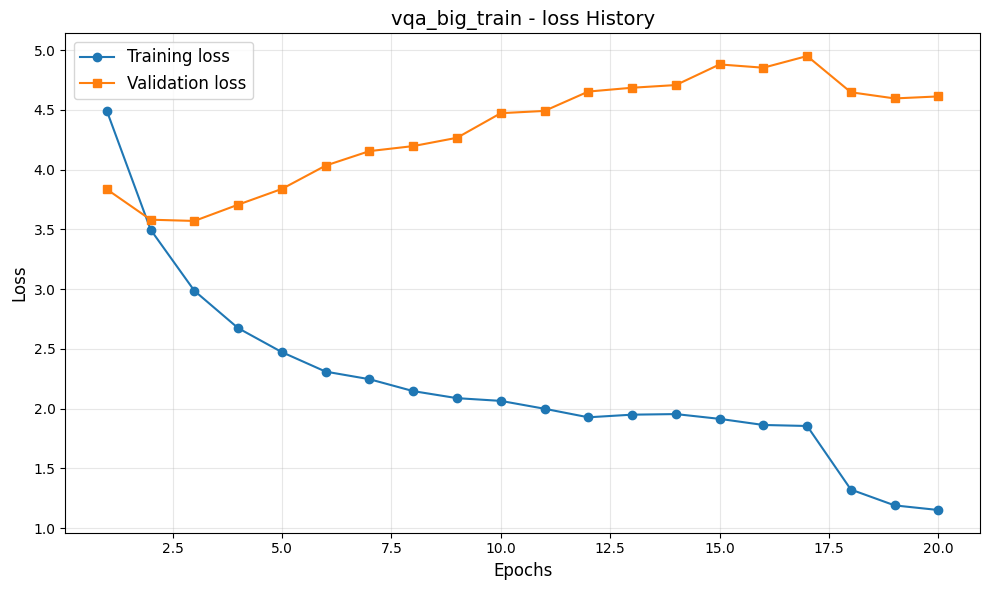

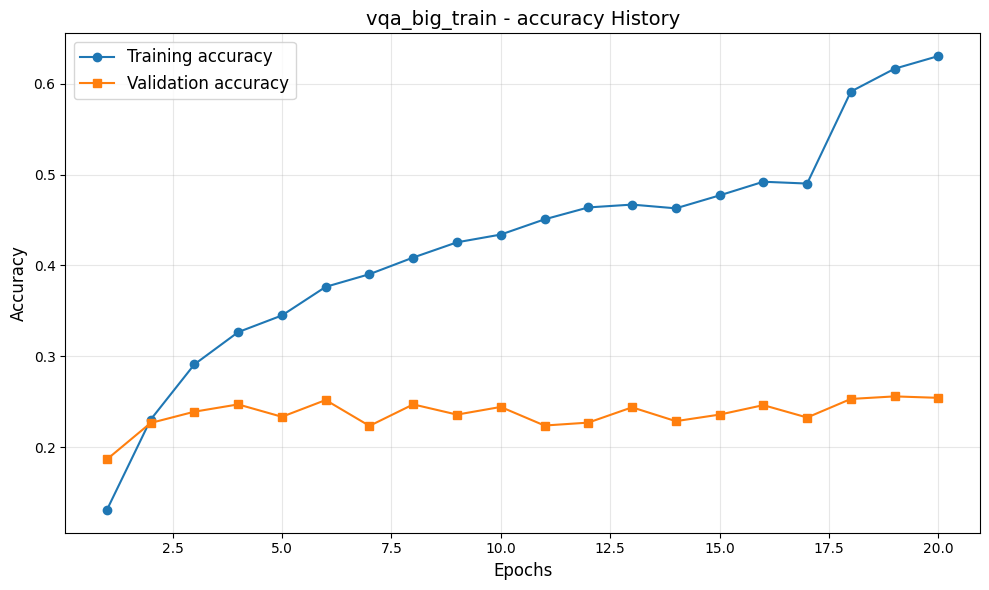

In [66]:
plot_metric_history(history[model_name], model_name,'loss')
plot_metric_history(history[model_name], model_name,'accuracy')